# Waiter's Tip Dataset

Table of Contents:

1. Data Analysis
    - Data Description
    - Data Loading
    - Exploratory Data Analysis (EDA)
        - Correlation Heatmap
        - Relationship between variables
        - Scatter-matrix
        - Distribution Plots
        - Box Plots
        - Count Plots
    - Data Preprocessing
2. Machine Learning
    - Model Selection
    - Hyperparameter tuning
3. Conclusions

# 1. Data Analysis

## Data Description

(https://www.kaggle.com/datasets/jsphyg/tipping)

Ever wonder how much to tip your waiter? One dedicated waiter meticulously recorded information about each tip he received over a few months while working at a restaurant. In total, he documented 244 tips. 

Columns (7): 

    - Total Bill (dollars)
    - Tip (dollars)
    - Sex (Male/Female)
    - Smoker (Yes/No)
    - Day (Mon/Tue/Wed/Thu/Fri/Sat/Sun)
    - Time (Dinner/Lunch)
    - Size [of party] (number)

## Data Loading and Cleanup

In [74]:
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import seaborn as sns
sns.set_theme(style='ticks')
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, skew, ttest_ind, f_oneway

from sklearn.preprocessing import LabelEncoder, PowerTransformer, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

In [75]:
#Create DataFrame object
df = pd.read_csv('tips.csv'); df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [76]:
df.describe()

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


In [77]:
#Check for NA values
df.isnull().sum()

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

In [78]:
#Check for duplicates
df.duplicated().sum()

1

In [79]:
#Remove duplicates and confirm removal
df.drop_duplicates(inplace=True); df.duplicated().sum()

0

In [80]:
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [81]:
#Define categorical and numerical columns
categorical_cols = []
numerical_cols = []

for col in df.columns:
    if (is_string_dtype(df[col])):
        categorical_cols.append(col)
    else:
        numerical_cols.append(col)

In [82]:
print(f'Categorical columns: {categorical_cols}\nNumerical columns: {numerical_cols}')

Categorical columns: ['sex', 'smoker', 'day', 'time']
Numerical columns: ['total_bill', 'tip', 'size']


## Exploratory Data Analysis

dodati još grafove tip-numeričke kategorije

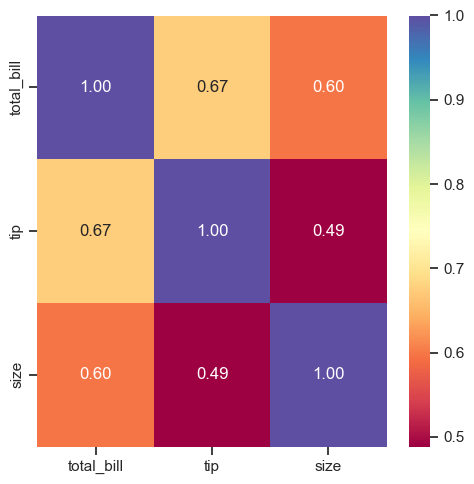

In [83]:
# Correlation Heatmap
figure = plt.figure(figsize=(5,5))
sns.heatmap(df[numerical_cols].corr(), annot=True, fmt='.2f', cmap='Spectral')
plt.tight_layout()
plt.savefig('images/01_Heatmap.png', bbox_inches='tight')
plt.show()

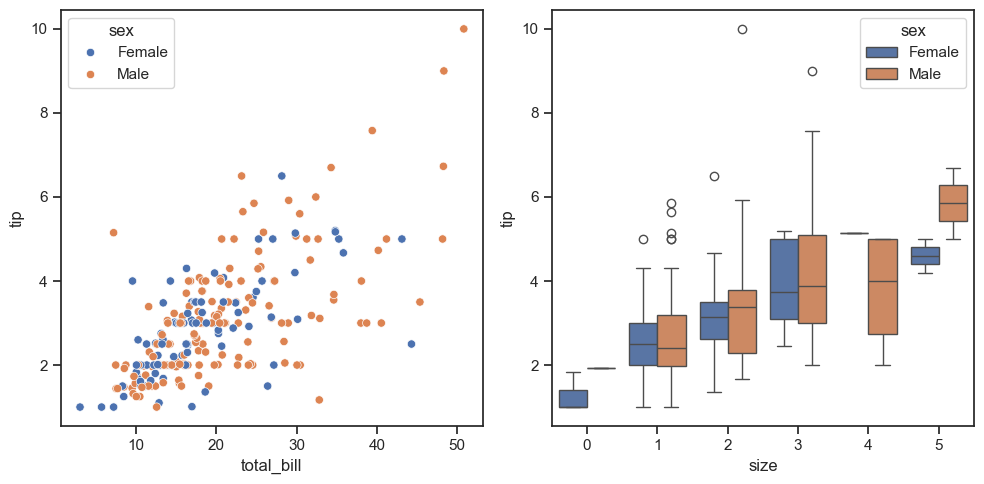

In [84]:
#Tip as a function of total bill and group size
fig, ax = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(10)

sns.scatterplot(data=df, x='total_bill', y='tip', hue='sex',ax=ax[0])
sns.boxplot(data=df, x='size', y='tip', hue='sex',ax=ax[1])

ax[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'{int(y)}'))
plt.tight_layout()
plt.savefig('images/02_Tip_bill_sizze.png', bbox_inches='tight')
plt.show()

array([[<Axes: xlabel='total_bill', ylabel='total_bill'>,
        <Axes: xlabel='tip', ylabel='total_bill'>,
        <Axes: xlabel='size', ylabel='total_bill'>],
       [<Axes: xlabel='total_bill', ylabel='tip'>,
        <Axes: xlabel='tip', ylabel='tip'>,
        <Axes: xlabel='size', ylabel='tip'>],
       [<Axes: xlabel='total_bill', ylabel='size'>,
        <Axes: xlabel='tip', ylabel='size'>,
        <Axes: xlabel='size', ylabel='size'>]], dtype=object)

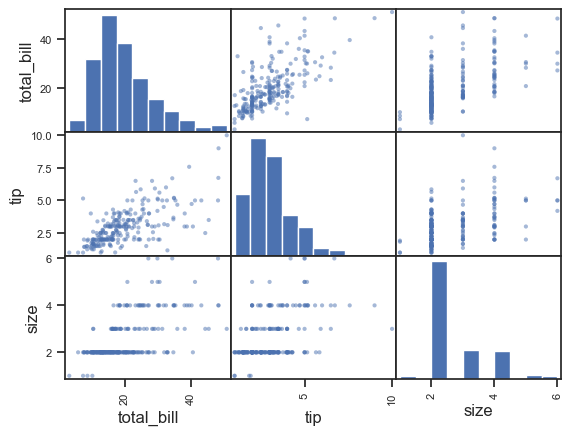

In [85]:
#Scatter-matrix (Pandas)
pd.plotting.scatter_matrix(df[numerical_cols])

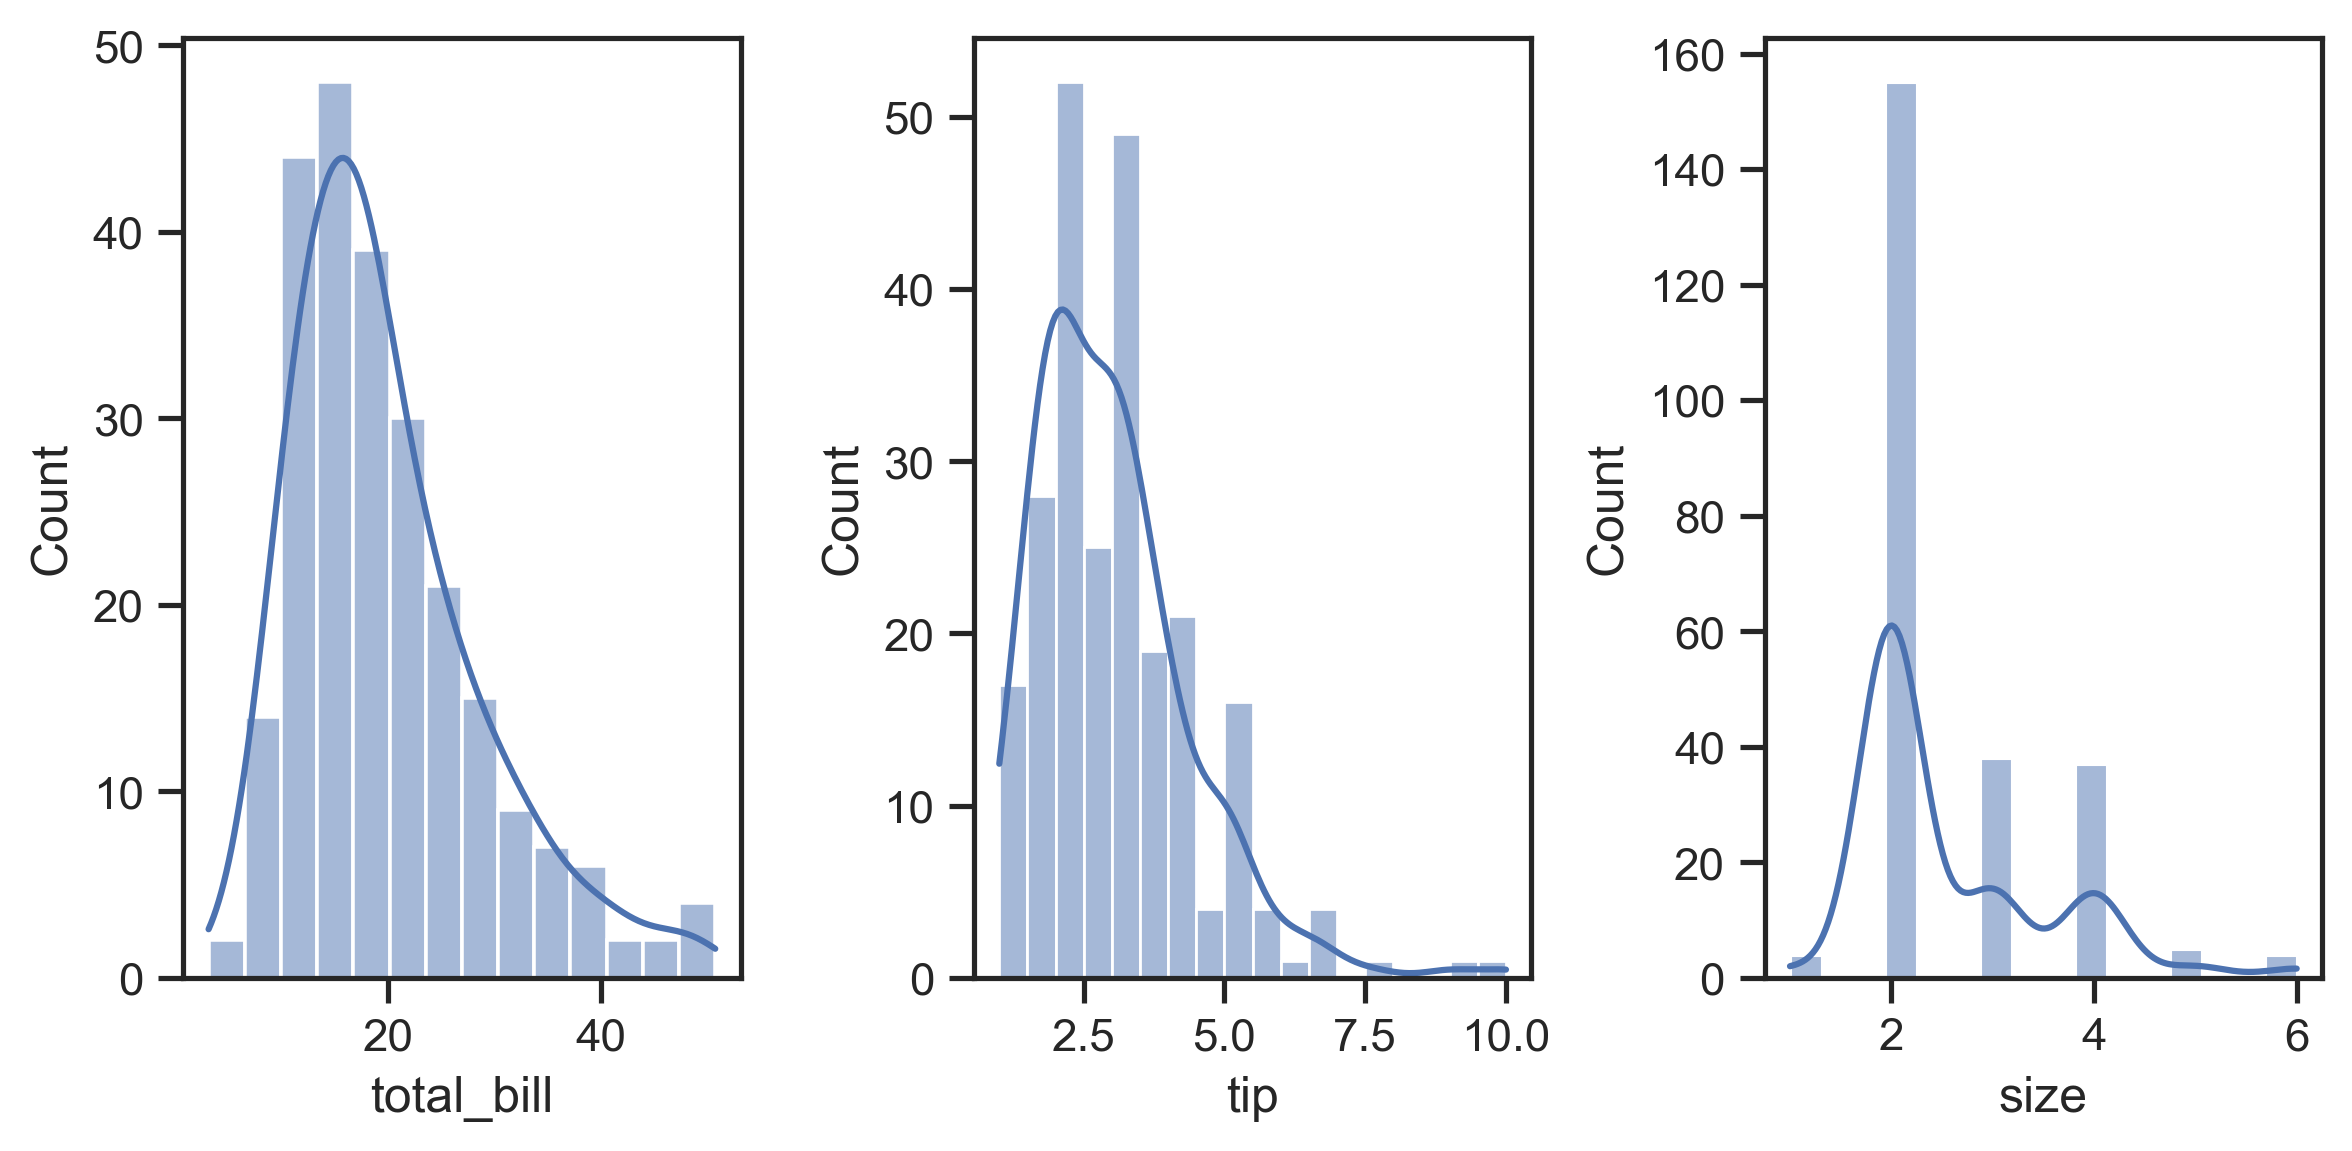

In [86]:
#Plotting distributions of numerical columns
fig = plt.figure(figsize=(8,4), dpi=300)
for i,col in enumerate(numerical_cols):
    plt.subplot(1, 3, i+1)
    sns.histplot(data=df, x=col, kde=True)
plt.tight_layout()
plt.savefig('images/01_Distributions_orig.png', bbox_inches='tight')
plt.show()

The numerical data is obviously skewed. It will be skew-normalized in the Pre-processing section.

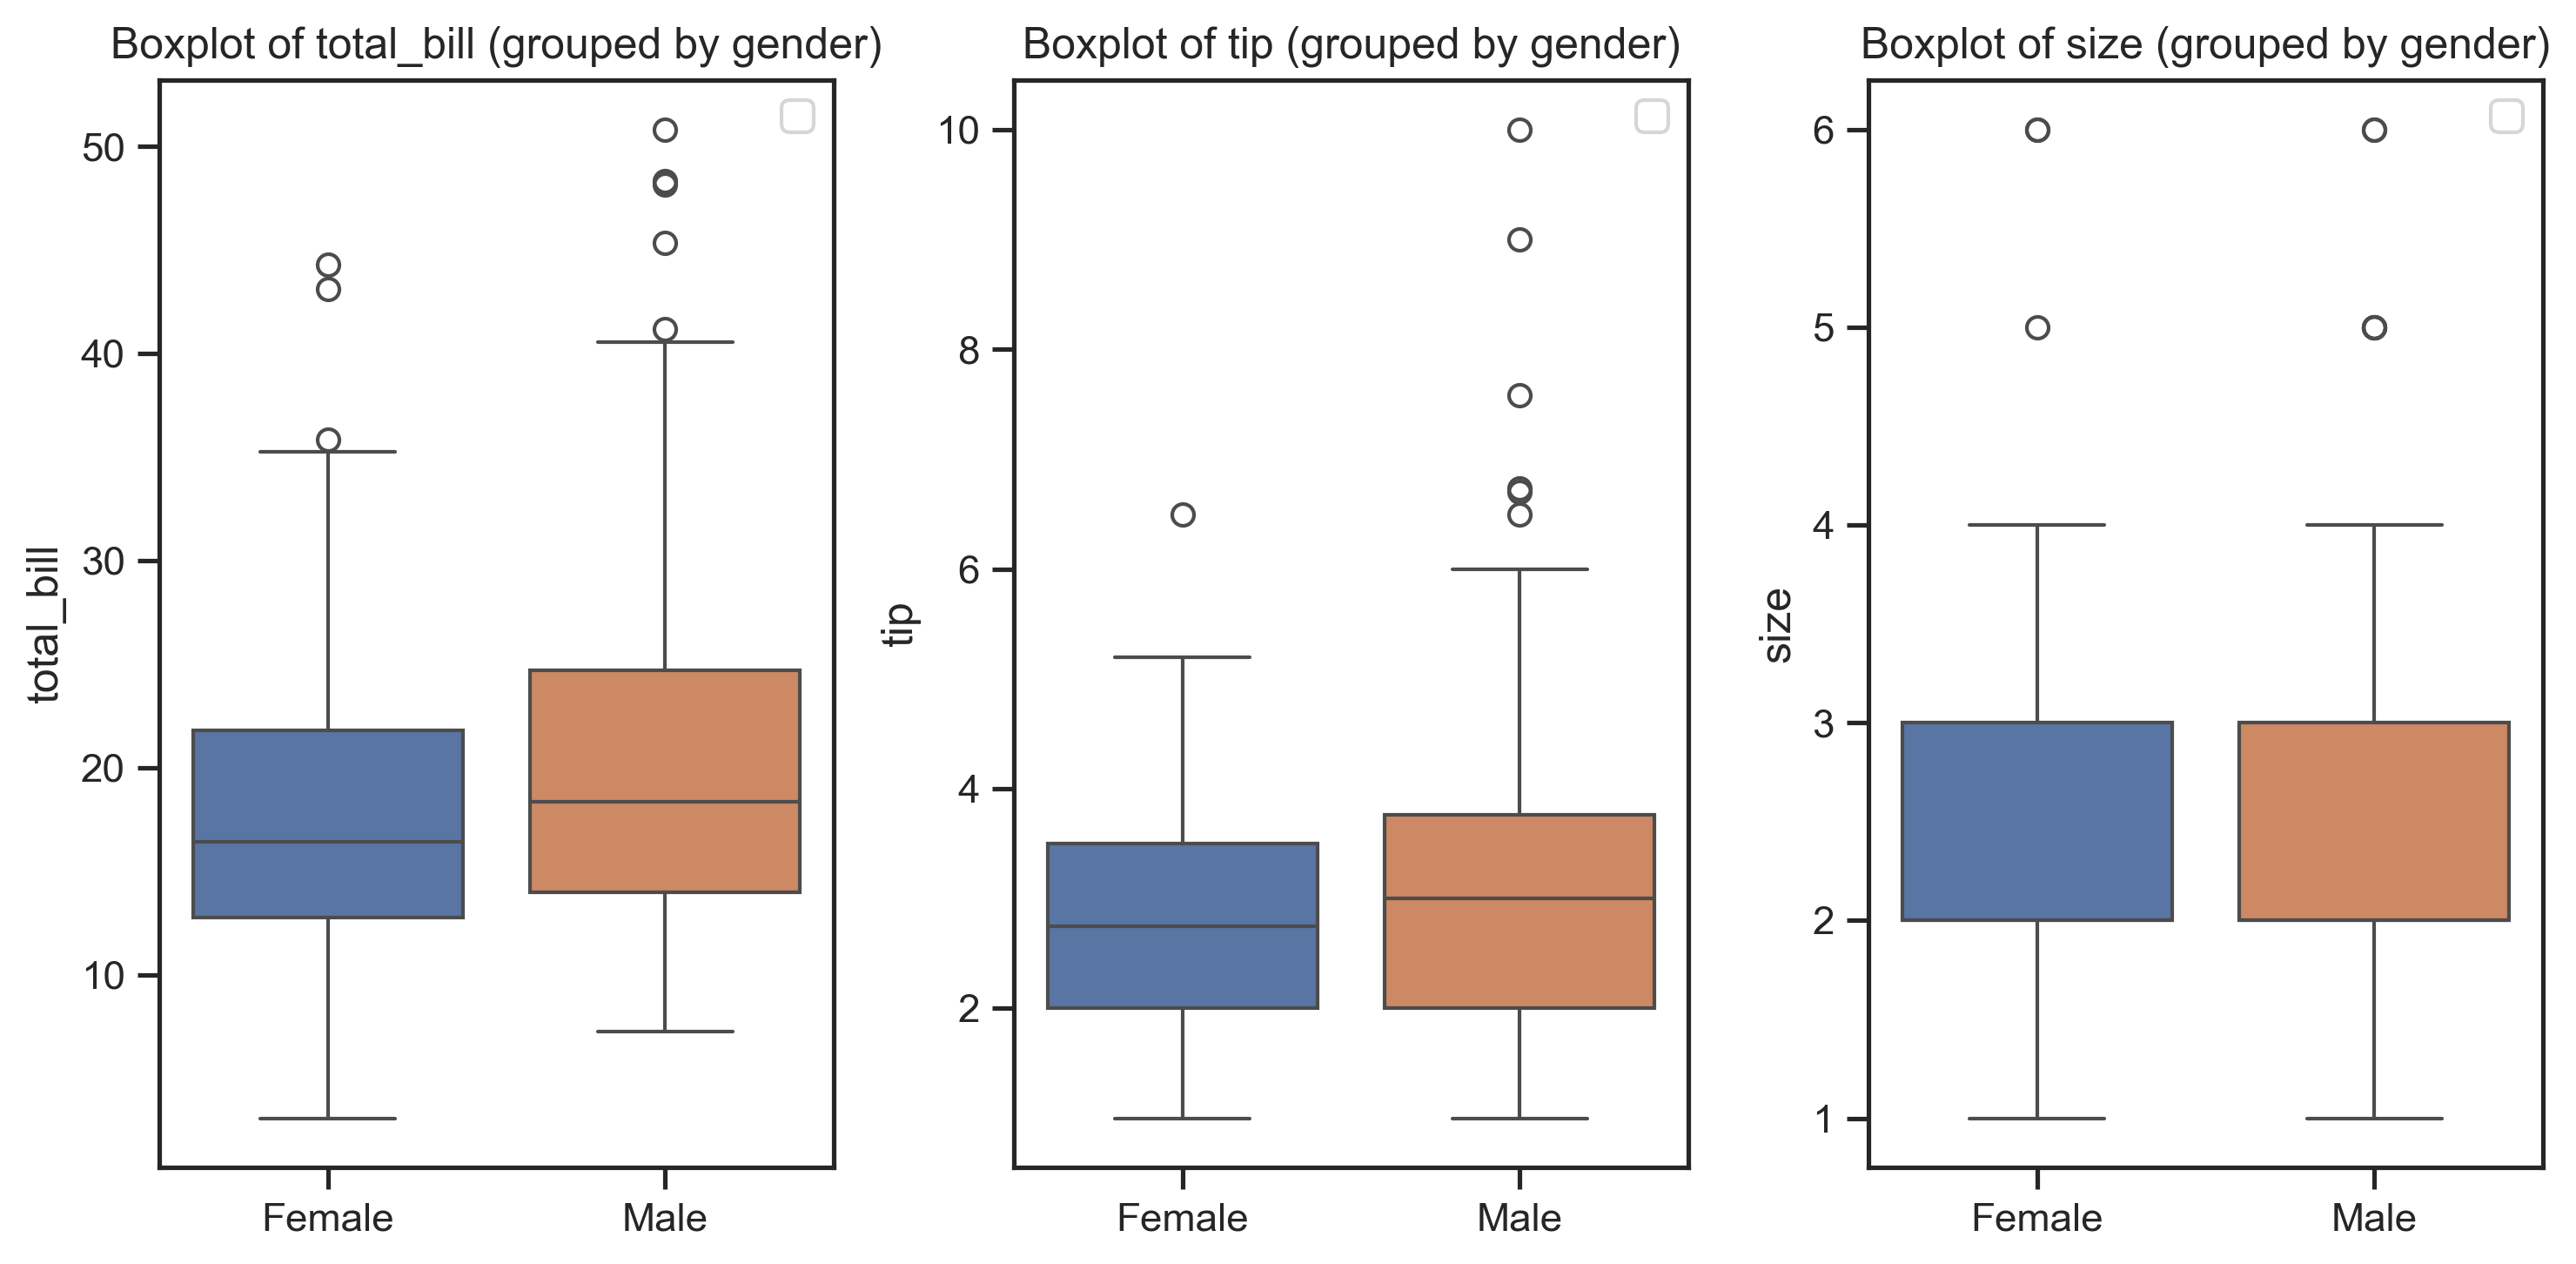

In [87]:
#Plotting Boxplots for numerical data
fig = plt.figure(figsize=(10,5), dpi=300)
for i, col in enumerate(numerical_cols):
    plt.subplot(1,3, i+1)
    sns.boxplot(x='sex', y=col, data=df, hue='sex')
    plt.legend('')
    plt.xlabel('')
    plt.ylabel(f'{col}')
    plt.title(f'Boxplot of {col} (grouped by gender)')
    plt.xticks(ticks=[0,1], labels=['Female', 'Male'])

plt.tight_layout()
plt.savefig('images/01_Boxplots_orig.png', bbox_inches='tight')
plt.show()

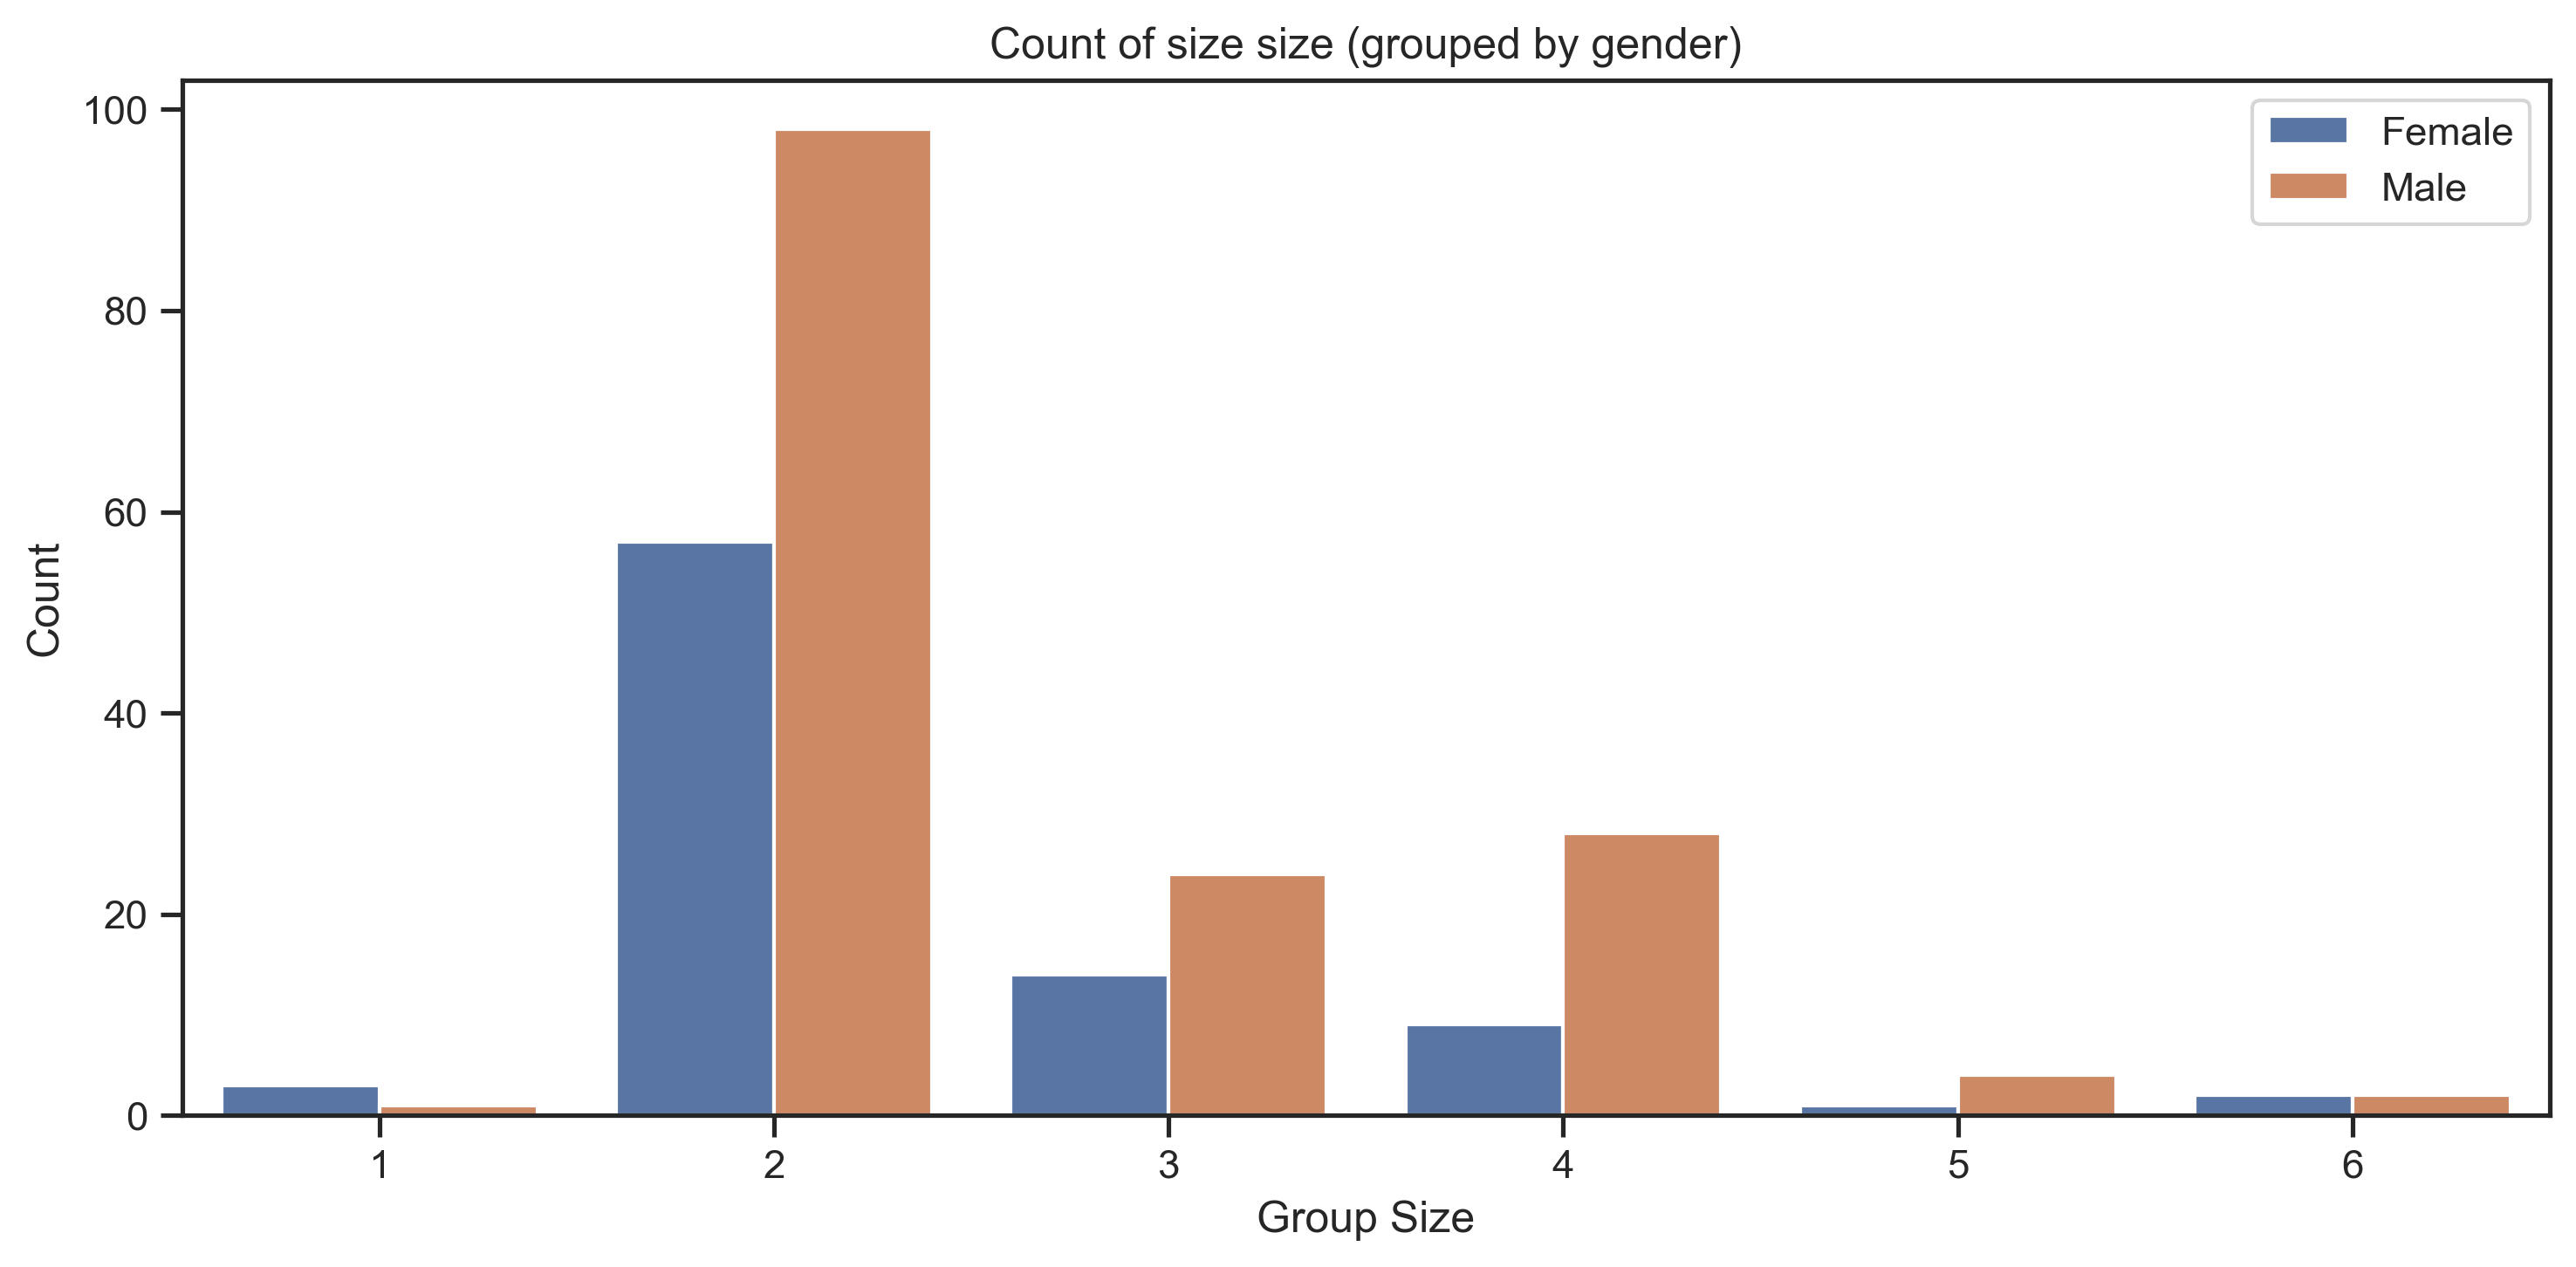

In [88]:
#Plotting Countplots for numerical data
fig = plt.figure(figsize=(10,5), dpi=300)
sns.countplot(data=df, x=df['size'], hue='sex')
plt.legend(labels=['Female', 'Male'])
plt.xlabel('Group Size')
plt.ylabel('Count')
plt.title(f'Count of {col} size (grouped by gender)')
#plt.xticks(ticks=[0,1], labels=['Female', 'Male'])

plt.tight_layout()
plt.savefig('images/01_Countplots.png', bbox_inches='tight')
plt.show()

## Data Pre-processing

In [89]:
#Removing outliers outside IQR (Inter-Quantile Range) on numerical columns
def remove_outliers(df, columns):
    for i, col in enumerate(columns):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - IQR * 1.5
        upper_bound = Q3 + IQR * 1.5
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

In [90]:
df = remove_outliers(df, numerical_cols)

In [91]:
#One-hot encoding categorical columns
label_dict = {}
labeler = LabelEncoder()
for i,col in enumerate(categorical_cols):
    df[col] = labeler.fit_transform(df[col])
    label_dict[col] = labeler

In [92]:
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,0,0,2,0,2
1,10.34,1.66,1,0,2,0,3
2,21.01,3.50,1,0,2,0,3
3,23.68,3.31,1,0,2,0,2
4,24.59,3.61,0,0,2,0,4
...,...,...,...,...,...,...,...
238,35.83,4.67,0,0,1,0,3
240,27.18,2.00,0,1,1,0,2
241,22.67,2.00,1,1,1,0,2
242,17.82,1.75,1,0,1,0,2


In [93]:
len(numerical_cols)

3

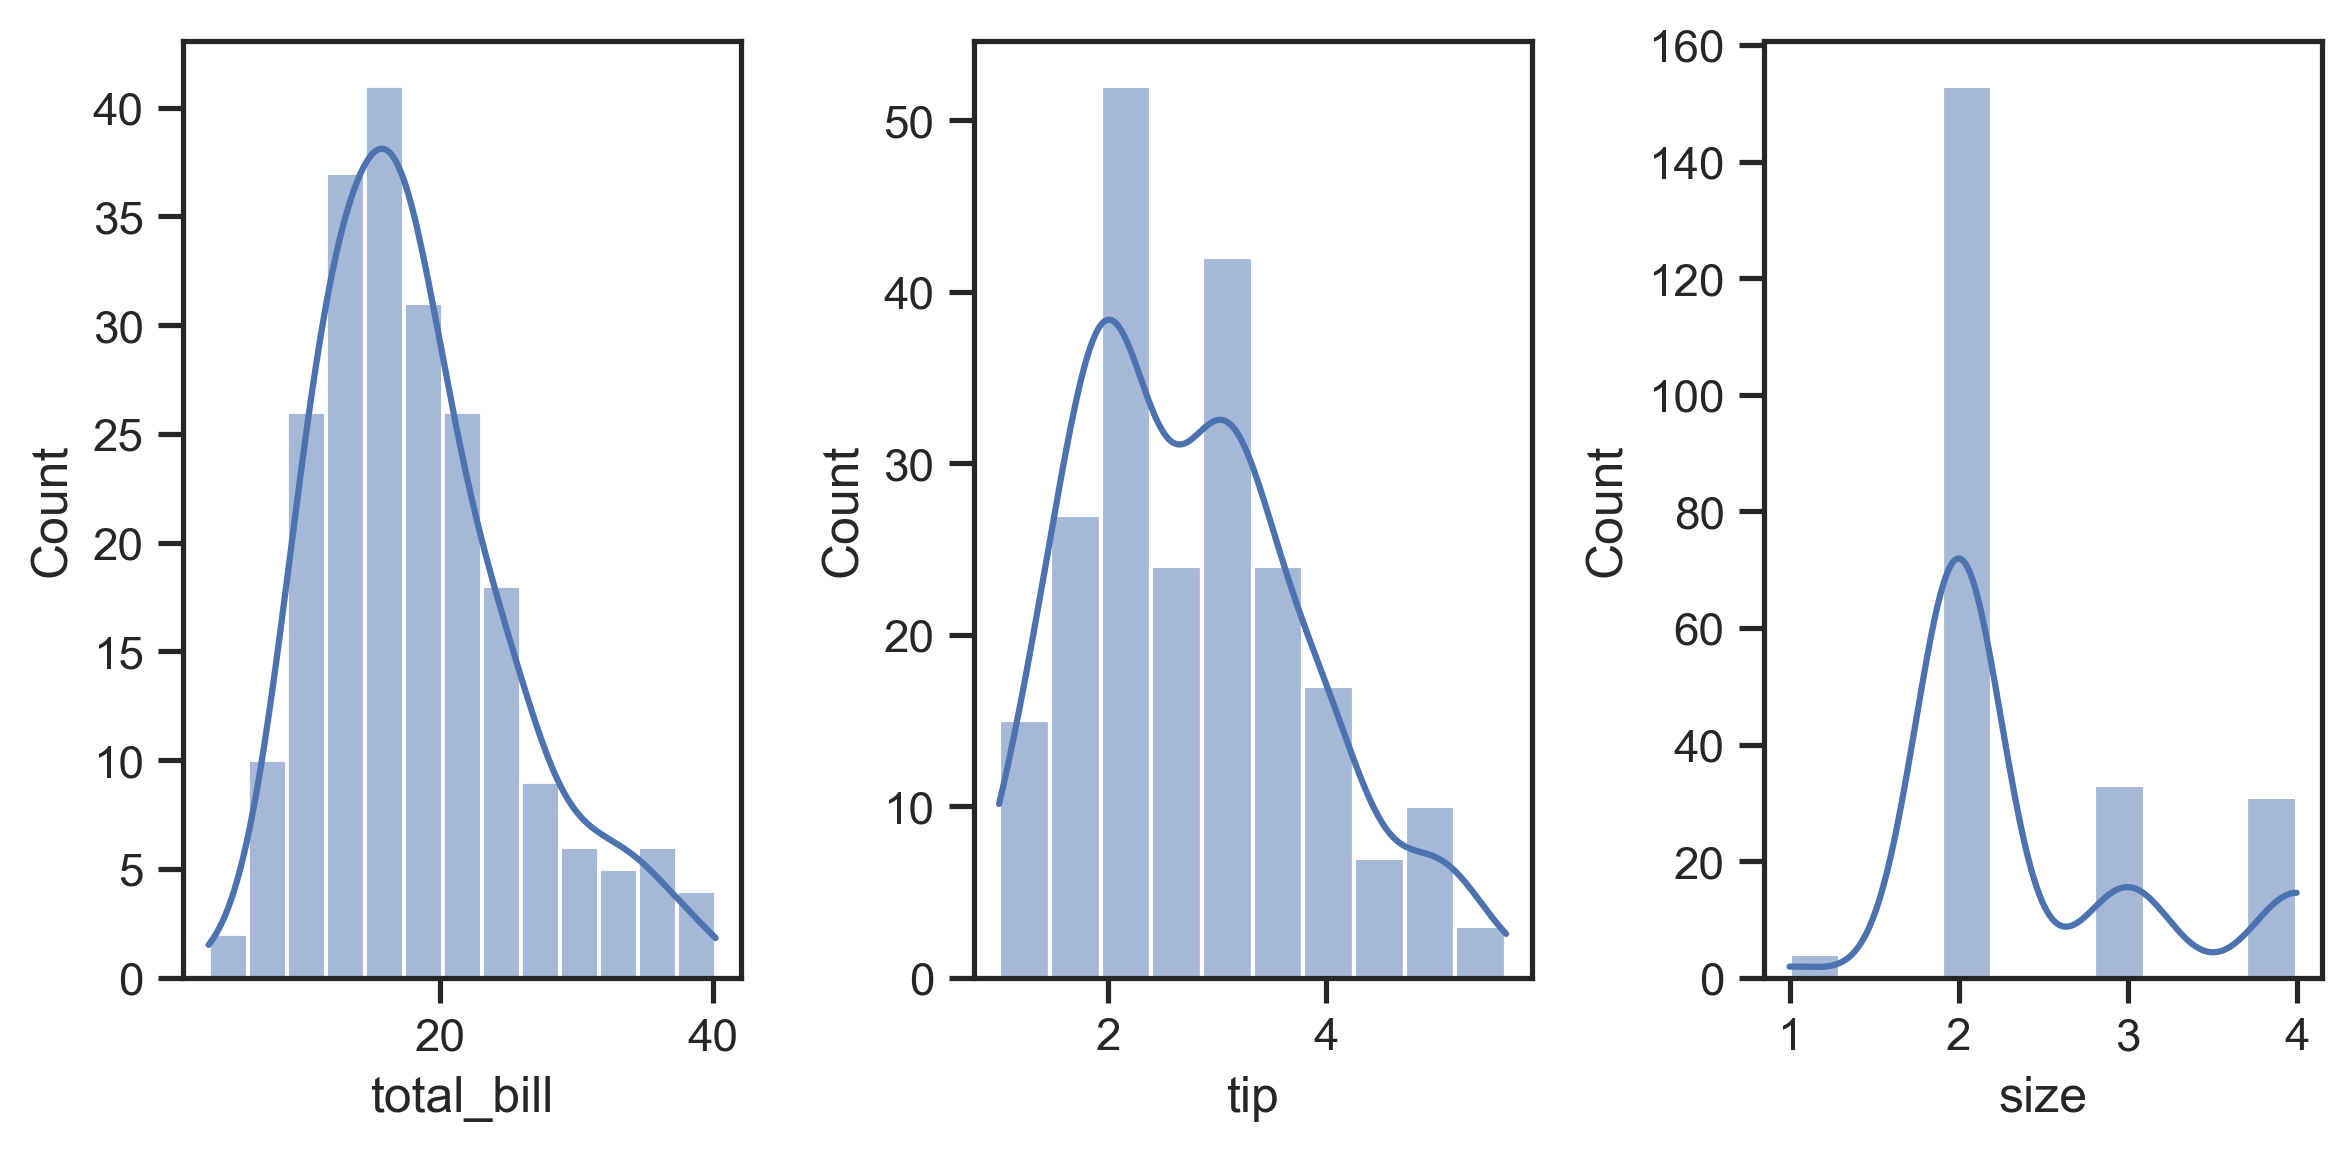

In [94]:
#Fixing skewness of numerical column distributions
fig = plt.figure(figsize=(8,4), dpi=300)
for i,col in enumerate(numerical_cols):
    plt.subplot(1, 3, i+1)
    sns.histplot(data=df, x=col, kde=True)
plt.tight_layout()
plt.show()

In [95]:
for col in numerical_cols:
    print(f'Skewness of {col}: {skew(df[col])}')

Skewness of total_bill: 0.8271368500606552
Skewness of tip: 0.5568756361580495
Skewness of size: 1.1799688899063168


In [96]:
def normalize_skew(df, columns):
    transformer = PowerTransformer(method='yeo-johnson')
    for i, col in enumerate(columns):
        if abs(skew(df[col])) > 0.5:
            df[col] = transformer.fit_transform(df[col].values.reshape(-1,1))
    return df

In [97]:
df = normalize_skew(df, numerical_cols)

The skew has now been brought within the range (-0.5, 0.5):

In [98]:
for col in numerical_cols:
    print(f'Skewness of {col}: {skew(df[col])}')

Skewness of total_bill: 0.0033815001040292214
Skewness of tip: 0.0010669007498665766
Skewness of size: -0.09674408612937464


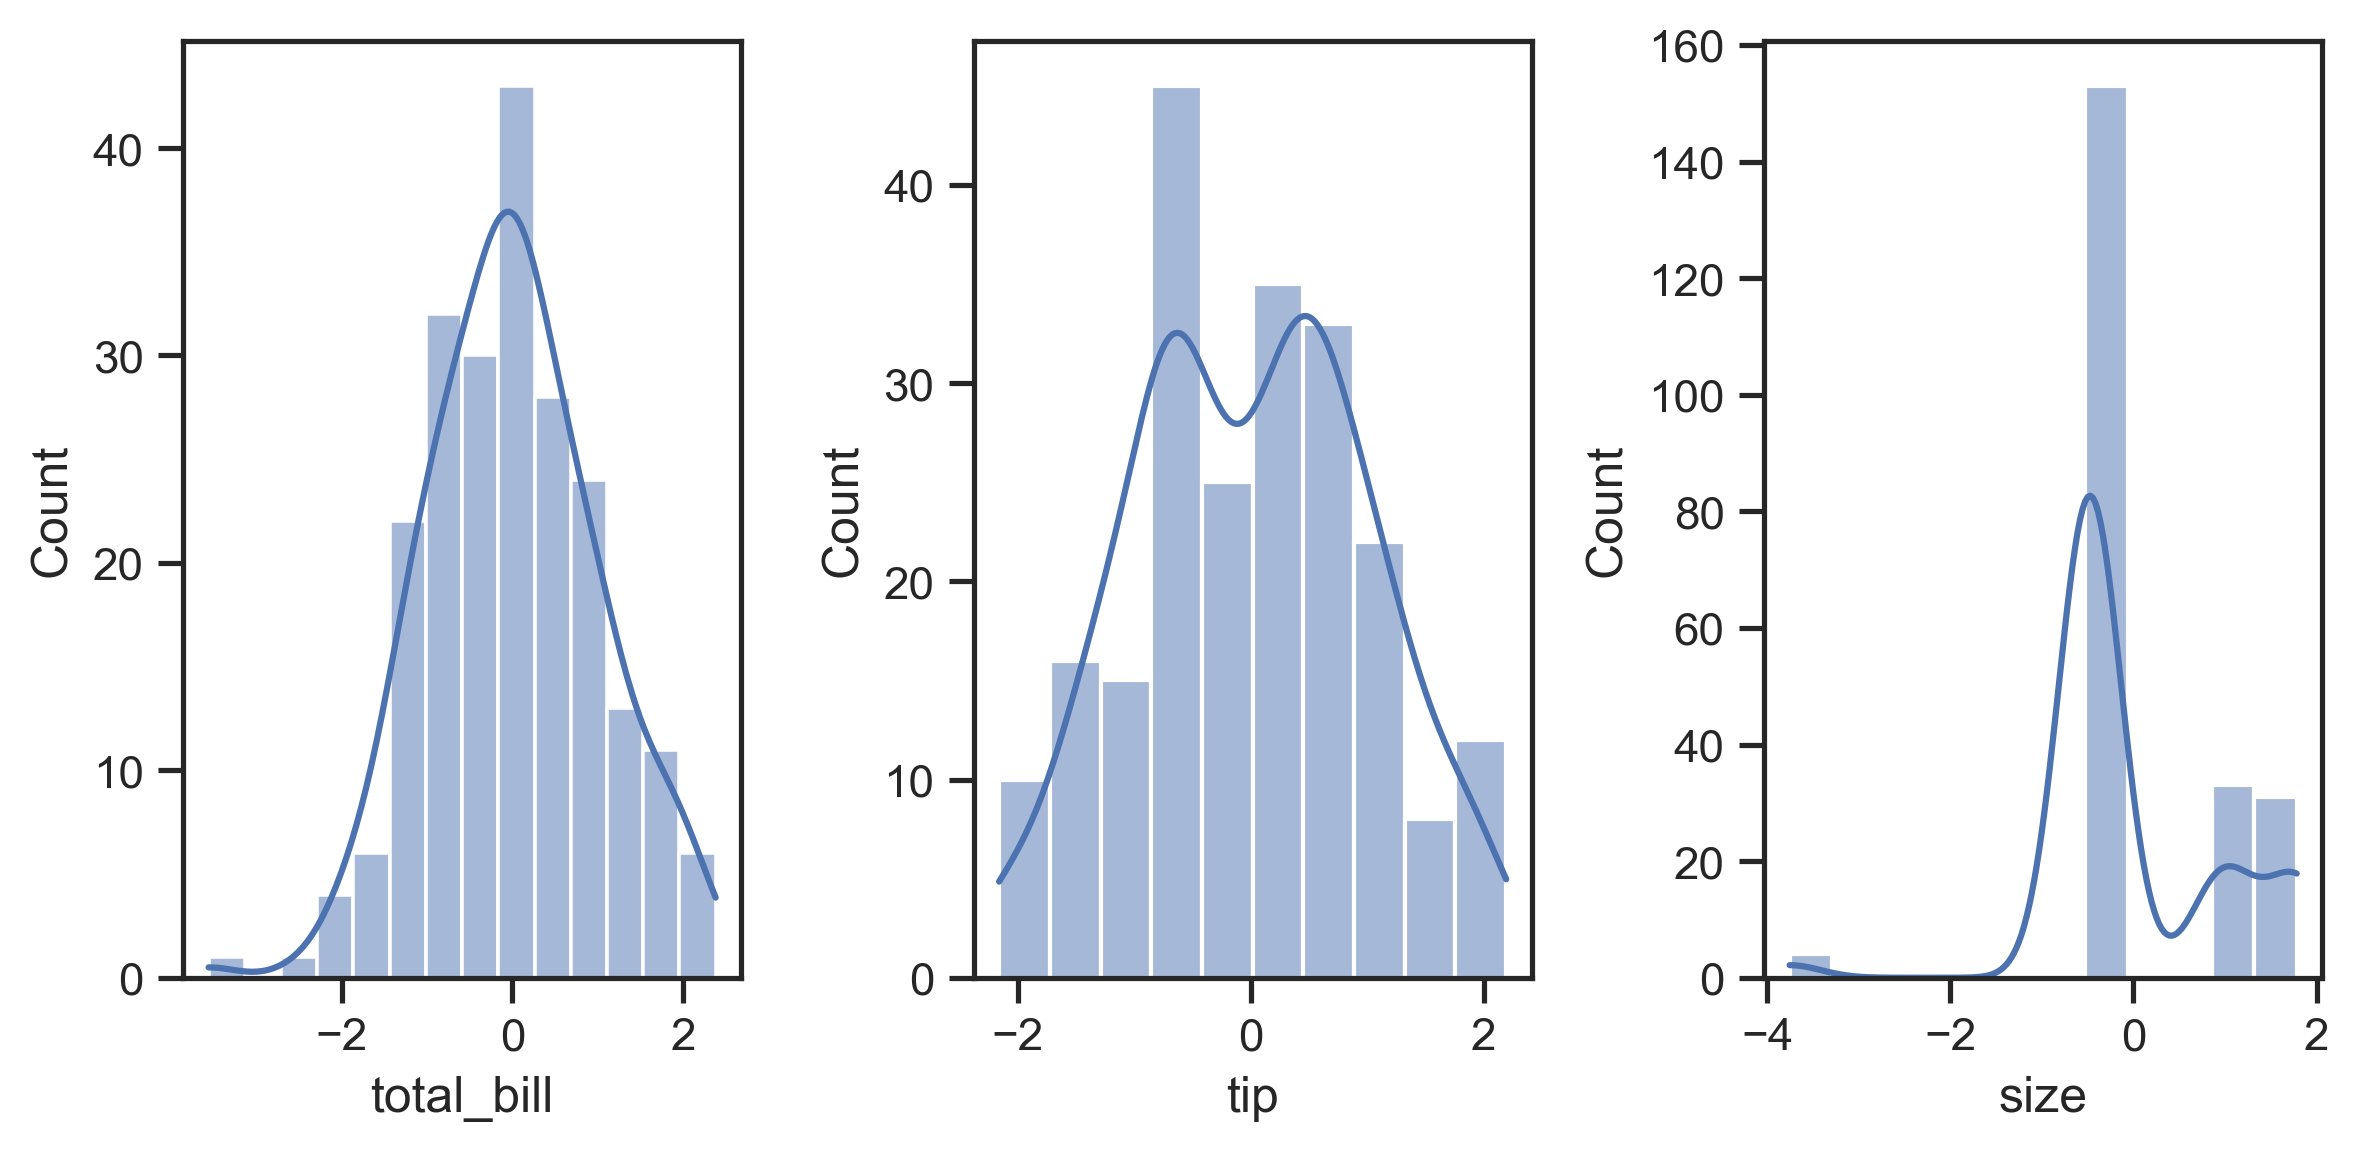

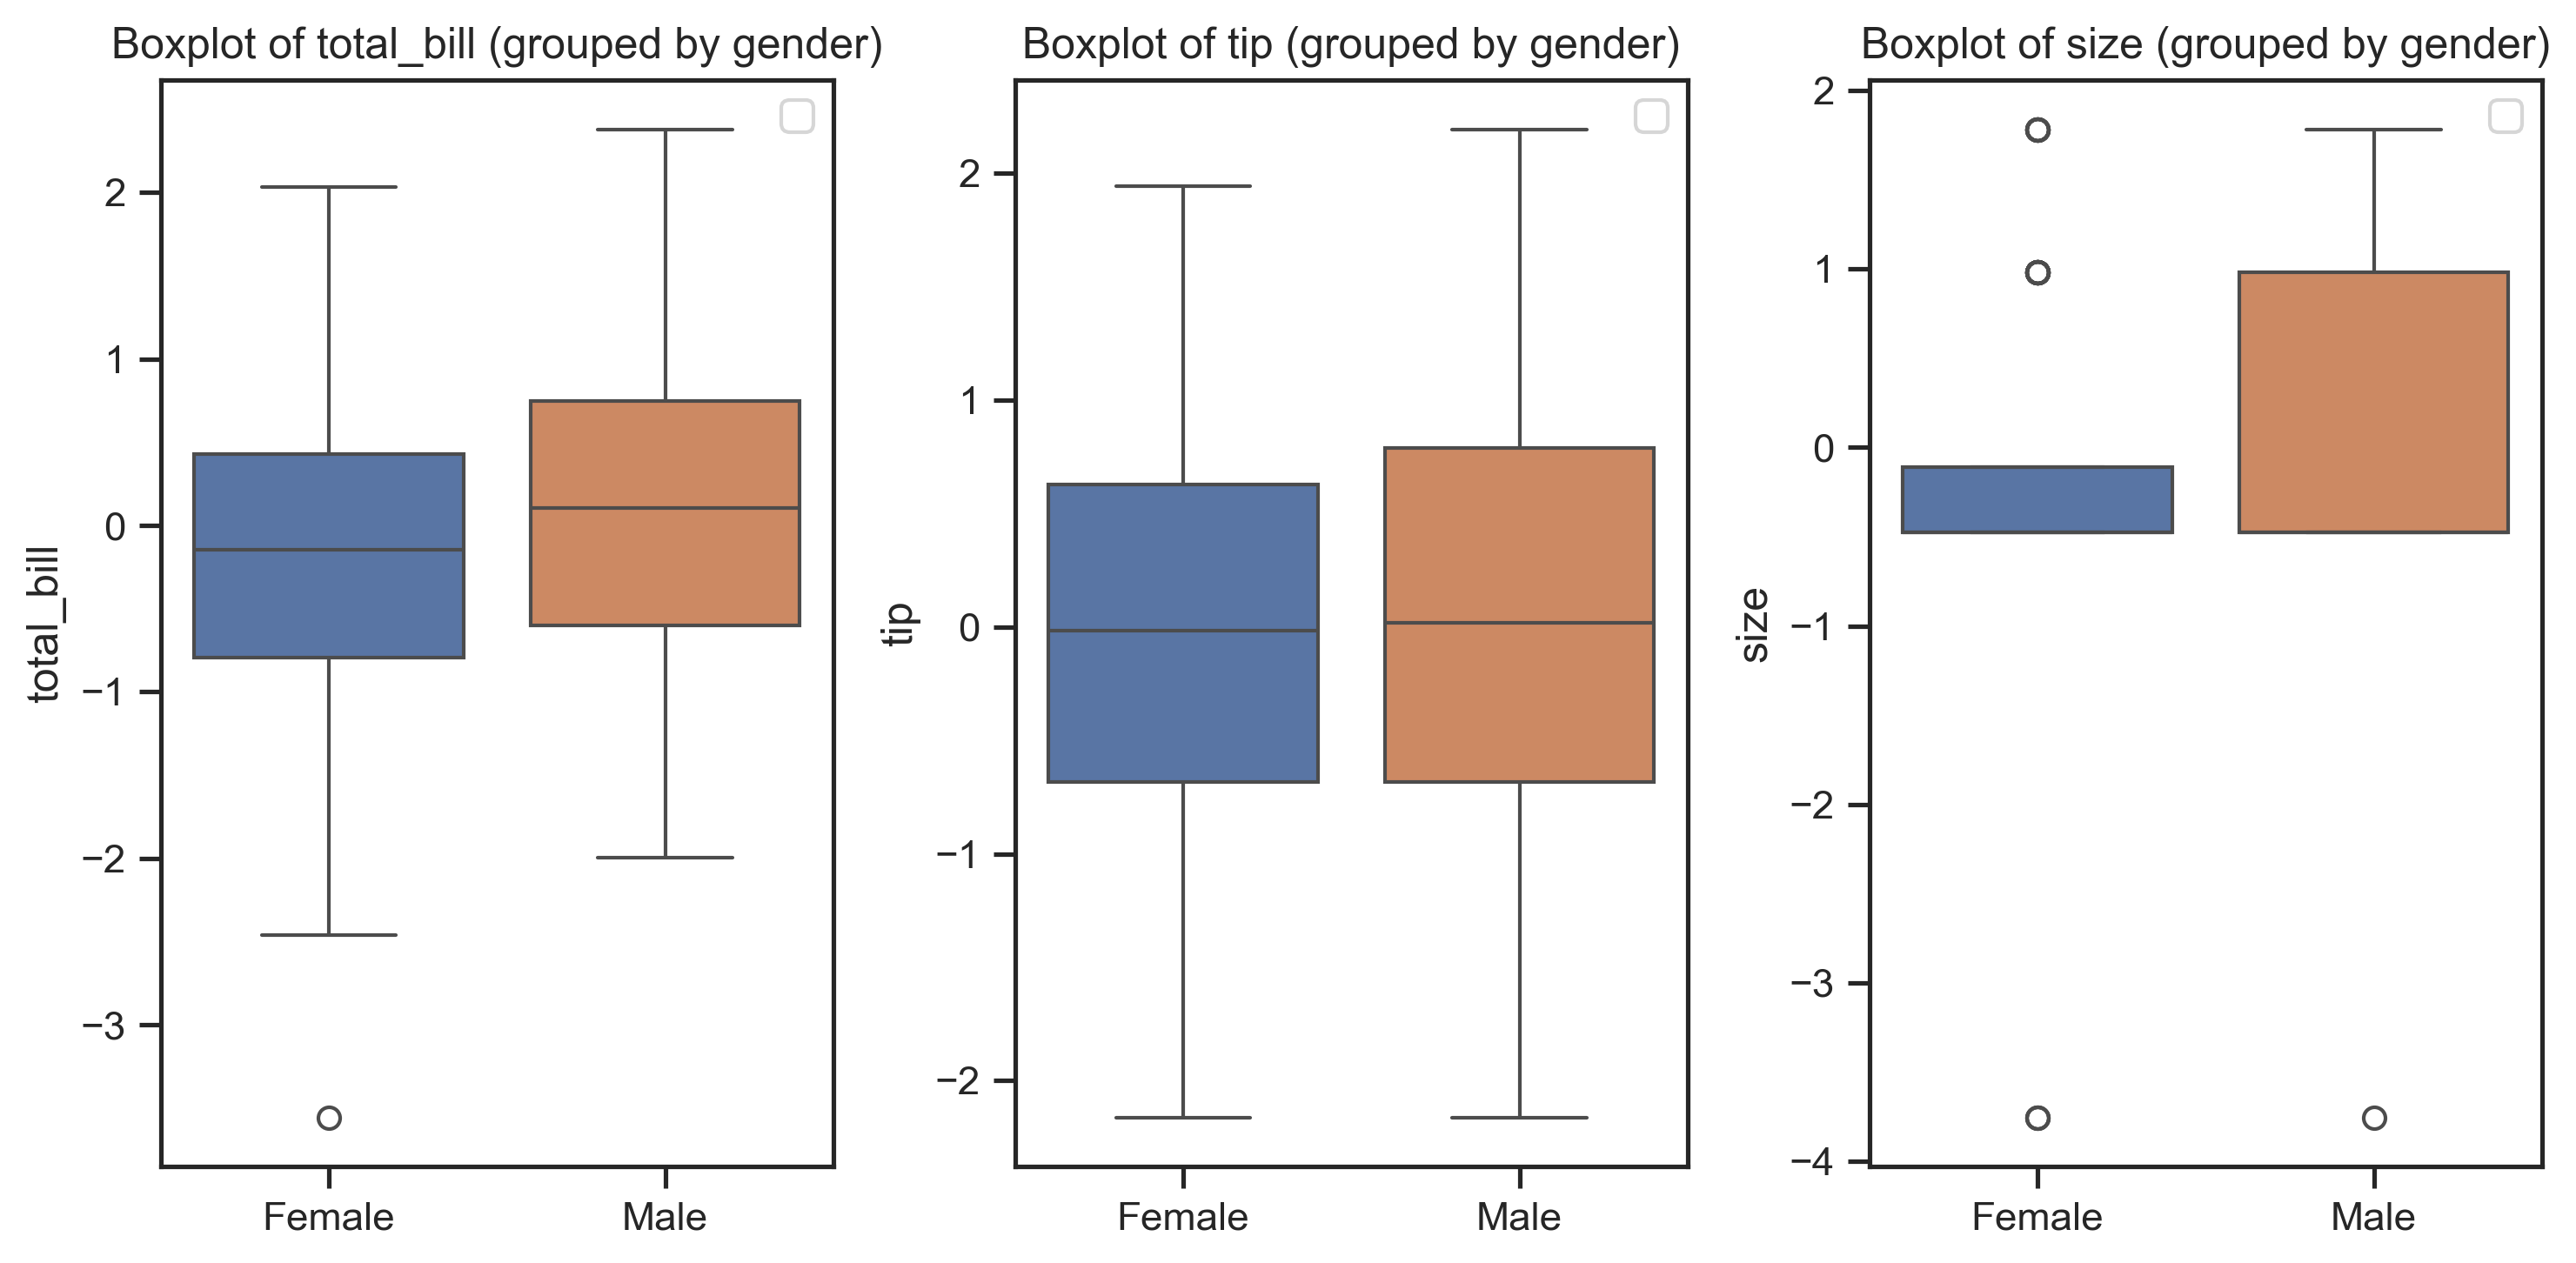

In [99]:
#Plots of data after outlier removal and skew-normalization:
#Distributions
fig = plt.figure(figsize=(8,4), dpi=300)
for i,col in enumerate(numerical_cols):
    plt.subplot(1, 3, i+1)
    sns.histplot(data=df, x=col, kde=True)
plt.tight_layout()
plt.savefig('images/02_Distributions_normalized.png', bbox_inches='tight')
plt.show()

#Boxplots
fig = plt.figure(figsize=(10,5), dpi=300)
for i, col in enumerate(numerical_cols):
    plt.subplot(1,3, i+1)
    sns.boxplot(x='sex', y=col, data=df, hue='sex')
    plt.legend('')
    plt.xlabel('')
    plt.ylabel(f'{col}')
    plt.title(f'Boxplot of {col} (grouped by gender)')
    plt.xticks(ticks=[0,1], labels=['Female', 'Male'])

plt.tight_layout()
plt.savefig('images/02_Boxplots_no_outliers.png', bbox_inches='tight')
plt.show()

# 2. Machine Learning

## Preparing Data

In [100]:
#Scaling numerical features
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [101]:
df

,total_bill,tip,sex,smoker,day,time,size
0,-0.030137,-2.143889,0,0,2,0,-0.474501
1,-1.226513,-1.120158,1,0,2,0,0.981117
2,0.524377,0.787556,1,0,2,0,0.981117
3,0.848152,0.631669,1,0,2,0,-0.474501
4,0.951924,0.874775,0,0,2,0,1.781836
...,...,...,...,...,...,...,...
238,2.033485,1.620732,0,0,1,0,0.981117
240,1.231517,-0.682176,0,1,1,0,-0.474501
241,0.729227,-0.682176,1,1,1,0,-0.474501
242,0.092153,-0.998908,1,0,1,0,-0.474501


In [102]:
X = df.drop('tip', axis=1)
y = df['tip']

In [103]:
print(f'X shape: {X.shape}\nY shape: {y.shape}')

X shape: (221, 6)
Y shape: (221,)


In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=35)
#X_test, X_cv, y_test, y_cv = train_test_split(X_left, y_left, train_size=0.5, random_state=35)

In [105]:
print(f'X_train shape: {X_train.shape}\nX_test shape: {X_test.shape}')

X_train shape: (176, 6)
X_test shape: (45, 6)


## Model Selection

The machine learning models we will use and evaluate are:
- Linear Regression
- Lasso Regression
- Linear SVR
- Neural Network (Multi Layer Percerpton Regressor: MLPR)
- Decision Tree Regression
- Random Forest Regression
- XGBoost Regression (XGBRegressor)

from the SciKit Learn and xgboost libraries. The hyperparameters will be determined through the use of GridSearchCV.

Getting a feel for the models:

In [106]:
#Linear Regression
linear = LinearRegression()
linear.fit(X_train, y_train)
linear.score(X_test, y_test)

0.44804894345876056

In [107]:
#Linear SVR
linear_svr = LinearSVR(dual=True)
linear_svr.fit(X_train, y_train)
linear_svr.score(X_test, y_test)

0.4411361641264575

In [108]:
#2nd Order Polynomial Regression
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly_2 = poly_2.fit_transform(X_train.to_numpy())
Y_train_poly_2 = poly_2.fit_transform(y_train.to_numpy().reshape(-1,1))

X_test_poly_2 = poly_2.fit_transform(X_test.to_numpy())
Y_test_poly_2 = poly_2.fit_transform(y_test.to_numpy().reshape(-1,1))

linear.fit(X_train_poly_2, Y_train_poly_2)
linear.score(X_test_poly_2, Y_test_poly_2)

0.21337820082198783

In [109]:
#3rd Order Polynomial Regression
poly_3 = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly_3 = poly_3.fit_transform(X_train.to_numpy())
Y_train_poly_3 = poly_3.fit_transform(y_train.to_numpy().reshape(-1,1))

X_test_poly_3 = poly_3.fit_transform(X_test.to_numpy())
Y_test_poly_3 = poly_3.fit_transform(y_test.to_numpy().reshape(-1,1))

linear.fit(X_train_poly_3, Y_train_poly_3)
linear.score(X_test_poly_3, Y_test_poly_3)

-3.9023503050575834

In [110]:
#MLPRegresor
MLPR = MLPRegressor(max_iter=500)
MLPR.fit(X_train, y_train)
MLPR.score(X_test, y_test)

c:\Users\jom4n\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


0.3731273724456128

In [111]:
#Decision Tree Regression
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)
decision_tree.score(X_test, y_test)

0.16047834650036374

In [112]:
#Random Forest Regression
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
random_forest.score(X_test, y_test)

0.13755823520647303

In [113]:
#XGB Regression
xgb_regressor = XGBRegressor()
xgb_regressor.fit(X_train, y_train)
xgb_regressor.score(X_test, y_test)

0.12767714672223263

## Hyperparameter tuning

In [114]:
models = {
    'linear_regression': {
        "model": LinearRegression(),
        'params': {
            'copy_X' : [True, False],
            'fit_intercept' : [True, False],
            'n_jobs' : [1,2,3],
            'positive' : [True, False]
        }
    },
    'lasso': {
        'model': Lasso(),
        'params': {
            'alpha':[1,2],
            'fit_intercept':[True,False],
            'max_iter':[1000,2000,5000],
            'warm_start':[True,False],
            'selection': ['random', 'cyclic']
        }
    },
    'decision_tree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'criterion':['absolute_error', 'squared_error', 'friedman_mse'],
            'splitter': ['best','random']
        }
    },
    'LinearSVR':{
        'model': LinearSVR(),
        'params': {
            'C':[1,5,10,20],
            'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
            'fit_intercept': [True,False],
            'max_iter': [1000,2000,5000,7000,10000],
            'dual':[True]
        }
    },
    'MLPR':{
        'model': MLPRegressor(),
        'params': {
            'solver': ['lbfgs', 'sgd', 'adam'],
            'learning_rate': ['constant', 'invscaling', 'adaptive'],
            'max_iter': [200, 1000, 2000, 5000],
            'shuffle': [True,False]
        }
    },
    'XGB':{
        'model': XGBRegressor(),
        'params': {
            "learning_rate": (0.05, 0.10, 0.15),
            "max_depth": [ 3, 4, 5, 6, 8]
        }
    }
}

In [72]:
scores = []
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=35)
def find_best_algorithm(models, X, y):
    for model_name, config in models.items():
        gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False, error_score='raise')
        gs.fit(X,y)
        scores.append({
            'Model': model_name,
            'Best Score': gs.best_score_,
            'Best Parameters': gs.best_params_,
            '$R^2$ score': r2_score(y, gs.predict(X))
        })
    return pd.DataFrame(scores, columns=['Model', 'Best Score', 'Best Parameters', '$R^2$ score']).sort_values(by='Best Score', ascending=False)

In [ ]:
pd.set_option('display.max_colwidth', 1000)
find_best_algorithm(models, X,y)

c:\Users\jom4n\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\jom4n\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\jom4n\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\jom4n\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\jom4n\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\jom4n\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number 

,Model,Best Score,Best Parameters,$R^2$ score
0,linear_regression,0.389392,"{'copy_X': True, 'fit_intercept': False, 'n_jobs': 1, 'positive': True}",0.395291
4,MLPR,0.382285,"{'learning_rate': 'constant', 'max_iter': 2000, 'shuffle': True, 'solver': 'sgd'}",0.408541
3,LinearSVR,0.353862,"{'C': 1, 'dual': True, 'fit_intercept': False, 'loss': 'squared_epsilon_insensitive', 'max_iter': 10000}",0.399836
5,XGB,0.228519,"{'learning_rate': 0.05, 'max_depth': 3}",0.657901
1,lasso,-0.008857,"{'alpha': 1, 'fit_intercept': False, 'max_iter': 1000, 'selection': 'random', 'warm_start': True}",0.000000
2,decision_tree,-0.348487,"{'criterion': 'friedman_mse', 'splitter': 'random'}",1.000000


# 3. Conclusions

Afer investigating the performance of these models we can conclude that:
- The overall best performing model is Linear Regression with a balanced accuracy score of 38.9% and an $R^2$ score of 39.5%. The optimal parameters are the ones described in the table above.
- The overall performance of the algorithm is not very good. This is likely due to the small number of training examples (N=221) which results in overfitting.
- A proposed solution is to gather more data and then train the models again.